In [1]:
import anndata
import numpy as np
import scvelo as scv
import scipy as sp
import sys
import torch
import os

sys.path.append('../')
import velovae as vv

In [2]:
filename = '../data/Pancreas/output_vanillapp.h5ad'
#filename = '/nfs/turbo/umms-welchjd/yichen/data/scRNA/braindev_pp.h5ad'
adata = anndata.read_h5ad(filename)

In [ ]:
#adata.obs['clusters'] = adata.obs['leiden'].to_numpy()
adata.obs["tprior"] = adata.obs.tprior - adata.obs.tprior.min()

In [ ]:
scv.pl.scatter(adata, basis='umap', figsize=(8,6), color='clusters', save='/home/gyichen/velovae/figures/Dentategyrus/umap.png')
adata.obs.keys()

In [ ]:
Ngene = 2000
vv.preprocess(adata, Ngene)

In [3]:
figure_path = '/home/gyichen/velovae/figures/Pancreas/Rho'
model_path = '/home/gyichen/velovae/checkpoints/Pancreas/Rho'
#data_path = '/scratch/blaauw_root/blaauw1/gyichen'
data_path = '../data/Pancreas/Rho'
adata.X.shape

(3696, 2000)

In [4]:
Cz = 5
model = vv.VanillaVAEpp(adata, 20, Cz, hidden_size=(500,250,250,500), tprior=None, N_ind=5, device='gpu')

In [5]:
config_vae = {'num_epochs':300, 'test_epoch':25, 'save_epoch':50, 
                  'learning_rate':1e-4, 'learning_rate_ode':1e-4, 'lambda':1e-3, 
                  'neg_slope':0, 'reg_t':1.0, 'reg_z':1.0, 'batch_size':128,
    }

In [ ]:
def sampleGenes(adata, n):
    variable = adata.var['highly_variable'].to_numpy()
    total = adata.var['mean_counts'].to_numpy()
    idx_sort = np.flip(np.argsort(total))
    genes = adata.var_names.to_numpy()
    #sort genes based total counts
    variable = variable[idx_sort]
    genes = genes[idx_sort]
    
    genes = genes[variable]
    #idx = np.random.choice(np.sum(variable), n, replace=False)
    return genes[:n]

In [6]:
#gene_plot = ['Auts2', 'Dync1i1', 'Gm3764', 'Mapt', 'Nfib', 'Rbfox1', 'Satb2', 'Slc6a13', 'Srrm4', 'Tcf4']
gene_plot = ['Pcsk2','Dcdc2a','Gng12','Cpe','Smoc1','Tmem163','Ank', 'Ppp3ca']
#gene_plot = ['Ank3','Arpp21','Epha3','Grin2b','Grm5','Plxna4','Robo2','Tle4']
#gene_plot = ['Ppp3ca','Tmsb10','Hn1','Tcea1']
#gene_plot = sampleGenes(adata, 8)
model.train(adata, config=config_vae, plot=True,gene_plot=gene_plot, figure_path=figure_path)

------------------------- Train a rho-VAE -------------------------
***      Creating  Dataset      ***
***          Finished.          ***
***     Creating optimizers     ***
***          Finished.          ***
***        Start training       ***
Total Number of Iterations Per Epoch: 29
Epoch 1: Loss = 105.64226531982422, 	 Total Time =   0 h :  0 m :  5 s
Epoch 25: Loss = 77.83470916748047, 	 Total Time =   0 h :  0 m : 26 s
Epoch 50: Loss = 19.748380661010742, 	 Total Time =   0 h :  0 m : 54 s
Epoch 75: Loss = 12.852352142333984, 	 Total Time =   0 h :  1 m : 16 s
Epoch 100: Loss = 10.23984432220459, 	 Total Time =   0 h :  1 m : 52 s
Epoch 125: Loss = 6.624493598937988, 	 Total Time =   0 h :  2 m : 24 s
Epoch 150: Loss = 5.019935131072998, 	 Total Time =   0 h :  3 m :  1 s
Epoch 175: Loss = 4.3080854415893555, 	 Total Time =   0 h :  3 m : 32 s
Epoch 200: Loss = 3.5616915225982666, 	 Total Time =   0 h :  4 m :  9 s
Epoch 225: Loss = 3.048414468765259, 	 Total Time =   0 h :  4 

In [ ]:
model.decoder.t0.shape

In [8]:
model.saveModel(model_path, 'encoder_vanillapp', 'decoder_vanillapp')
model.saveAnnData(adata, 'vanillapp', data_path, file_name='output_vanillapp.h5ad')


# Post Analysis

In [9]:
from sklearn.decomposition import PCA
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
#figure_path = '../figures/Braindev/VanillaVAEpp'
#model_path = '../checkpoints/Braindev/VanillaVAEpp'
#data_path = '../data/Braindev'

In [10]:
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'lime', 'grey', \
   'olive', 'cyan', 'pink', 'gold', 'steelblue', 'salmon', 'teal', \
   'magenta', 'rosybrown', 'darkorange', 'yellow', 'greenyellow', 'darkseagreen', 'yellowgreen', 'palegreen', \
   'hotpink', 'navajowhite', 'aqua', 'navy', 'saddlebrown', 'black', 'maroon']

In [ ]:
#adata = anndata.read_h5ad('../data/Pancreas/output_vanillapp.h5ad')
adata = anndata.read_h5ad('../data/Pancreas/output.h5ad')

In [ ]:
Cz = 4
model = vv.VanillaVAEpp(adata, 20, Cz, hidden_size=(500,250,250,500), tprior=None, device='cpu')

In [ ]:
checkpoint1 = '../checkpoints/Pancreas/VanillaVAEpp/encoder_vanillapp.pt'
model.encoder.load_state_dict(torch.load(checkpoint1,map_location=model.device))
checkpoint2 = '../checkpoints/Pancreas/VanillaVAEpp/decoder_vanillapp.pt'
model.decoder.load_state_dict(torch.load(checkpoint2,map_location=model.device))
#model.saveAnnData(adata, 'vanillapp', data_path, 'output_braindev.h5ad')

## Analysis 1: Latent Representation

In [11]:
z = adata.obsm['vanillapp_z']
t = adata.obs['vanillapp_time'].to_numpy().reshape(-1,1)
#t0 = adata.layers['t0']
#u0 = adata.layers['u0']
#s0 = adata.layers['s0']
rho = adata.layers['vanillapp_rho']
ton = adata.var['vanillapp_ton'].to_numpy()
toff = adata.var['vanillapp_toff'].to_numpy()

In [12]:
pca = PCA(n_components=3)
rho_pca = pca.fit_transform(rho)
rho_pca

array([[-6.7946687 , -2.3938537 , -2.3375936 ],
       [ 9.224461  , -2.383529  , -1.0401055 ],
       [-7.0401387 , -3.2033525 , -2.4210799 ],
       ...,
       [ 8.4117775 , -2.167776  , -0.48335072],
       [-5.388508  , -3.7509553 ,  2.465864  ],
       [-5.9363394 , -3.8091402 , -1.5046886 ]], dtype=float32)

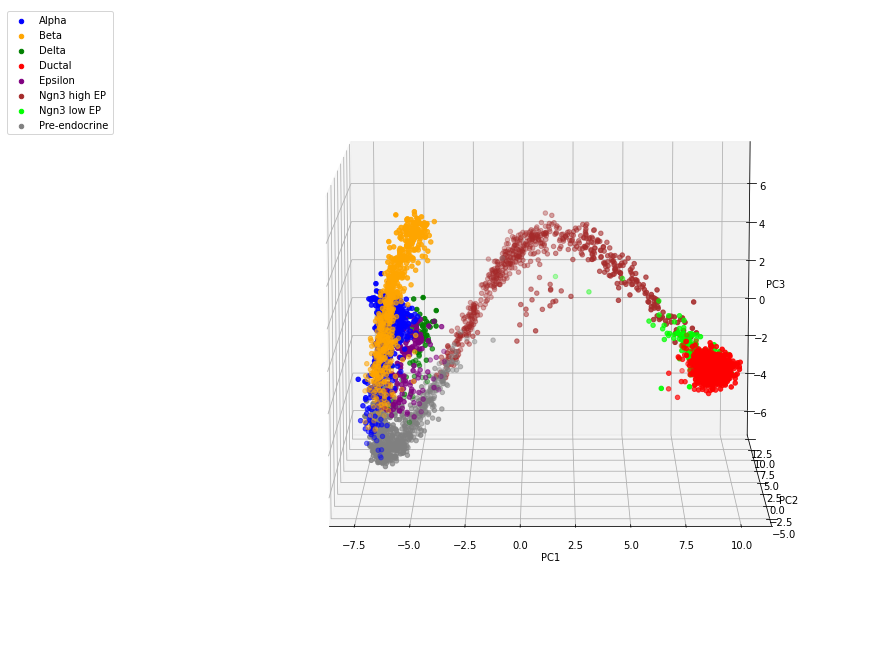

In [13]:
cell_labels = adata.obs['clusters'].to_numpy()
cell_types = np.unique(cell_labels)
fig=plt.figure(figsize=(15,12))
ax = fig.add_subplot(projection='3d')
ax.view_init(10, 270)
for i,x in enumerate((cell_types)):
    ax.scatter(rho_pca[cell_labels==x,0], rho_pca[cell_labels==x,1], rho_pca[cell_labels==x,2], label=x, color=colors[i])
    
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.legend(bbox_to_anchor=(-0.15,1.0), loc='upper right')
plt.show()
fig.savefig(figure_path+'/rho_pca.png')

In [ ]:
import umap

In [ ]:
umap_obj = umap.UMAP(n_neighbors=50, n_components=2, min_dist=0.5)
rho_umap = umap_obj.fit_transform(rho)

In [ ]:
cell_labels = adata.obs['clusters'].to_numpy()
cell_types = np.unique(cell_labels)
fig=plt.figure(figsize=(10,10))
for i,x in enumerate((cell_types)):
    plt.scatter(rho_umap[cell_labels==x,0], rho_umap[cell_labels==x,1], label=x, color=colors[i])
plt.legend(bbox_to_anchor=(-0.15,1.0), loc='upper right')
plt.show()

In [ ]:
umap_obj = umap.UMAP(n_neighbors=50, n_components=2, min_dist=0.25)
z_umap = umap_obj.fit_transform(z)

In [ ]:
fig=plt.figure(figsize=(10,10))
for i,x in enumerate((cell_types)):
    plt.scatter(z_umap[cell_labels==x,0], z_umap[cell_labels==x,1], label=x, color=colors[i])
plt.legend(bbox_to_anchor=(-0.15,1.0), loc='upper right')
plt.show()
fig.savefig(figure_path+'/z_umap.png')

In [ ]:
adata.obsm['X_z'] = z_umap
#adata2.obsm['X_z'] = z_umap
adata.obsm['X_rho'] = rho_umap
#adata2.obsm['X_rho'] = rho_umap

## Analysis 2: Gene Expression

In [34]:
gidx = np.where(adata.var_names=='March4')[0][0]
#gidx=120
rho_g = rho[:, gidx]

In [15]:
Uhat, Shat = model.decoder.predSU(torch.tensor(t).to(model.device).view(-1,1), torch.tensor(z).to(model.device))
uhat, shat = Uhat[:, gidx].detach().cpu().numpy(), Shat[:, gidx].detach().cpu().numpy()

In [ ]:
u, s = adata.layers['Mu'][:,gidx].squeeze(), adata.layers['Ms'][:,gidx].squeeze()
scaling = adata.var.vanillapp_scaling[gidx]
fig, ax = plt.subplots(3,1,figsize=(12,12))
L = 50
for i,x in enumerate((cell_types)):
    ax[0].plot(t[cell_labels==x], u[cell_labels==x]/scaling, '.', color=colors[i])
    ax[1].plot(t[cell_labels==x], s[cell_labels==x], '.', color=colors[i])
    ax[2].plot(t[cell_labels==x], rho[cell_labels==x, gidx], '.', color=colors[i])


ax[0].set_ylabel('U', fontsize=12, rotation=0)
ax[1].set_ylabel('S', fontsize=12, rotation=0)
ax[2].set_ylabel(r'$\rho$', fontsize=12, rotation=0)

fig.suptitle(adata.var_names[gidx])
plt.tight_layout()
fig.show()
fig.savefig(figure_path+f'/rho_{adata.var_names[gidx]}.png')

In [16]:
key='vanillapp'
V, U, S = vv.rnaVelocityRhoVAE(adata, key, use_raw=False, use_scv_genes=False)

Alpha 445
Beta 554
Delta 68
Ductal 0
Epsilon 124
Ngn3 high EP 0
Ngn3 low EP 0
Pre-endocrine 36


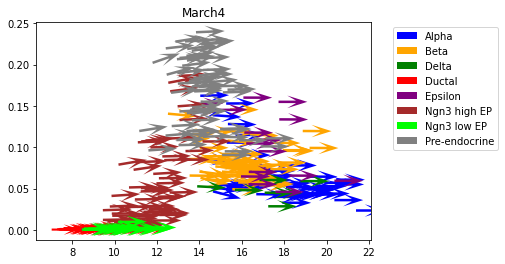

In [35]:
name = adata.var_names[gidx]
v = V[:, gidx]
u = U[:, gidx]
s = S[:, gidx]
dt = 0.2
s_ = s + v*dt

fig, ax = plt.subplots()
#ax.plot(t, s, '.', label='s')
#ax.plot(t, s_, '.', label='s+v*dt')
for i,x in enumerate(cell_types):
    print(x,np.sum(s_[cell_labels==x]-s[cell_labels==x]<0))
    ax.quiver(t[cell_labels==x][::10], s[cell_labels==x][::10], dt*np.ones((len(t[cell_labels==x][::10]))), v[cell_labels==x][::10]*dt, angles='xy', scale=0.5, scale_units='inches', headwidth=5.0, headlength=8.0, color=colors[i], label=x)
ax.set_title(name)
ax.legend(bbox_to_anchor=(1.05,1.0), loc='upper left')
fig.show()
fig.savefig(figure_path+f'/{name}_{key}_vel.png', bbox_inches='tight')

## Analysis 3: ODE Parameters

In [ ]:
alpha1, beta1, gamma1 = adata.var["vanillapp_alpha"].to_numpy(), adata.var["vanillapp_beta"].to_numpy(), adata.var["vanillapp_gamma"].to_numpy()
alpha2, beta2, gamma2 = adata2.var["vanilla_alpha"].to_numpy(), adata2.var["vanilla_beta"].to_numpy(), adata2.var["vanilla_gamma"].to_numpy()
alpha3, beta3, gamma3 = adata2.var["fit_alpha"].to_numpy(), adata2.var["fit_beta"].to_numpy(), adata2.var["fit_gamma"].to_numpy()
scaling = adata2.var["fit_scaling"].to_numpy()

In [ ]:
gene_mask = ~np.isnan(scaling)
alpha1 = alpha1[gene_mask]
beta1 = beta1[gene_mask]
gamma1 = gamma1[gene_mask]
alpha2 = alpha2[gene_mask]
beta2 = beta2[gene_mask]
gamma2 = gamma2[gene_mask]
alpha3 = alpha3[gene_mask]
beta3 = beta3[gene_mask] * scaling[gene_mask]
gamma3 = gamma3[gene_mask]

In [ ]:
print(np.sum(gene_mask))

In [ ]:
fig, ax = plt.subplots(3,1, figsize=(12,8))
ax[0].hist(alpha1, 50, range=(0, np.quantile(alpha1,0.95)), alpha=0.5, label='vanilla +')
ax[0].hist(alpha2, 50, range=(0, np.quantile(alpha2,0.95)), alpha=0.5, label='vanilla')
ax[0].hist(alpha3, 50, range=(0, np.quantile(alpha3,0.95)), alpha=0.5, label='scvelo')
ax[0].set_title(r'$\alpha$', fontsize=20)
ax[1].hist(beta1, 50, range=(0, np.quantile(beta1,0.95)), alpha=0.5)
ax[1].hist(beta2, 50, range=(0, np.quantile(beta2,0.95)), alpha=0.5)
ax[1].hist(beta3, 50, range=(0, np.quantile(beta3,0.95)), alpha=0.5)
ax[1].set_title(r'$\beta$', fontsize=20)
ax[2].hist(gamma1, 50, range=(0, np.quantile(gamma1,0.95)),alpha=0.5)
ax[2].hist(gamma2, 50, range=(0, np.quantile(gamma2,0.95)), alpha=0.5)
ax[2].hist(gamma3, 50, range=(0, np.quantile(gamma3,0.95)), alpha=0.5)
ax[2].set_title(r'$\gamma$', fontsize=20)
plt.tight_layout()
fig.legend()
fig.show()
fig.savefig(figure_path+'/hist_param.png')

In [ ]:
D=50
fig, ax = plt.subplots(3,1, figsize=(12,8))
ax[0].stem(alpha1[::D], label='vanilla +')
ax[0].stem(alpha2[::D], markerfmt='C1o', label='vanilla')
ax[1].stem(beta1[::D])
ax[1].stem(beta2[::D], markerfmt='C1o')
ax[2].stem(gamma1[::D])
ax[2].stem(gamma2[::D], markerfmt='C1o')
ax[0].set_ylim(0,np.quantile(alpha1, 0.98))
fig.show()

In [ ]:

print("Correlation to scvelo: [vanilla +, vanilla]")
print(f"alpha: {sp.stats.spearmanr(alpha1, alpha3)[0]:.3f}, {sp.stats.spearmanr(alpha2, alpha3)[0]:.3f}")
print(f"beta: {sp.stats.spearmanr(beta1, beta3)[0]:.3f}, {sp.stats.spearmanr(beta2, beta3)[0]:.3f}")
print(f"gamma: {sp.stats.spearmanr(gamma1, gamma3)[0]:.3f}, {sp.stats.spearmanr(gamma2, gamma3)[0]:.3f}")
print("Cosine Distance to scvelo: ")
print(f"alpha: {sp.spatial.distance.cosine(alpha1,alpha3):.3f}, {sp.spatial.distance.cosine(alpha2,alpha3):.3f}")
print(f"beta: {sp.spatial.distance.cosine(beta1,beta3):.3f}, {sp.spatial.distance.cosine(beta2,beta3):.3f}")
print(f"gamma: {sp.spatial.distance.cosine(gamma1,gamma3):.3f}, {sp.spatial.distance.cosine(gamma2,gamma3):.3f}")

# Project velocity to the UMAP of Z

In [ ]:
key='vanillapp'
figure_path = '../figures/Pancreas'
scv.tl.velocity_graph(adata, vkey=f'{key}_velocity', basis='umap')
scv.tl.velocity_embedding(adata, vkey=f'{key}_velocity', basis='umap')
scv.pl.velocity_embedding_stream(adata, vkey=f'{key}_velocity', basis='umap', figsize=(8,6), save=figure_path+f'/panc_{key}velrho.png')

In [ ]:
scv.tl.velocity_graph(adata, vkey=f'vanillapp_velocity', basis='rho')
scv.tl.velocity_embedding(adata, vkey=f'vanillapp_velocity', basis='rho')
scv.pl.velocity_embedding_stream(adata, vkey=f'vanillapp_velocity', basis='rho', figsize=(8,6), save=figure_path+f'/brain_vanillappvelz.png')

In [ ]:
key='vanillapp'
figure_path = '../figures/Pancreas'
name='Ppp3ca'
gidx = np.where(adata.var_names==name)[0][0]
v = adata.layers[f"{key}_velocity"][:, gidx]
print(np.sum(v<=0))
u = adata.layers['Mu'][:, gidx]
s = adata.layers['Ms'][:, gidx]
t = adata.obs[f"{key}_time"].to_numpy()
dt = 0.2
s_ = s + v*dt
fig, ax = plt.subplots()
ax.plot(t, s, '.', label='s')
ax.plot(t, s_, '.', label='s+v*dt')
ax.set_title(name)
ax.legend(bbox_to_anchor=(1.05,1.0), loc='upper left')
fig.show()
fig.savefig(figure_path+f'/{name}_rho_vel.png', bbox_inches='tight')

computing velocity graph (using 1/40 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:29) --> added 
    'vanillapp_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'vanillapp_velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file /home/gyichen/velovae/figures/Pancreas/Rho/panc_velrho.png


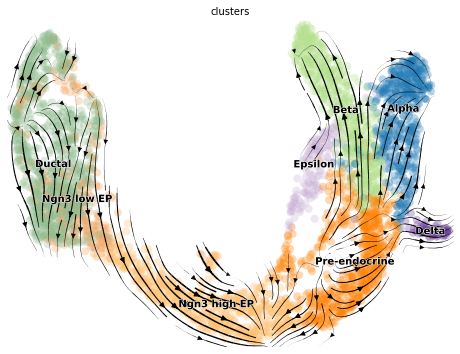

In [20]:
key='vanillapp'
scv.tl.velocity_graph(adata, vkey=f'{key}_velocity')
scv.tl.velocity_embedding(adata, vkey=f'{key}_velocity')
scv.pl.velocity_embedding_stream(adata, vkey=f'{key}_velocity', figsize=(8,6), save=figure_path+f'/panc_velrho.png')

In [ ]:
torch.nn.functional.one_hot(np.array([0,2,3]), 5)